In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

data1536 = pd.read_csv('20181004-1536welltest.txt',
                  skiprows =[0,1,2,3,4,5])

wells = data1536.loc[:,'Unnamed: 0':'Unnamed: 1']
layout1536 = pd.read_csv('20181015-1536PlateLayout3.csv')

wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[a]', 'AA')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[b]', 'AB')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[c]', 'AC')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[d]', 'AD')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[e]', 'AE')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.replace(r'[f]', 'AF')
wells['Unnamed: 0'] = wells['Unnamed: 0'].str.lower()
wells = wells['Unnamed: 0'].str.cat(wells['Unnamed: 1'].astype(str))

### The well names came off the platereader weird so this corrects them



data1536 = data1536.loc[:,'Unnamed: 2':].drop('Unnamed: 584', 
                              axis = 1)
name = pd.read_csv('20181004-1536welltest.txt',
                  nrows =3)['User: USER'][1]


data1536 = data1536.where(data1536['Unnamed: 2'] != 'unused ').dropna()
data1536 = data1536.rename(data1536['Unnamed: 2']).drop(['Unnamed: 2'],
                                    axis = 1)

data1536 = data1536.subtract(data1536['800'],
             axis = 0)
data1536.columns = data1536.columns.astype(int)
data1536.index= wells
data1536 = data1536.loc[:,300:]

data1536 = data1536.loc[layout1536[layout1536['[Prot]/µM'] != 0]['0']] ### eliminate empty wells
layout1536 = layout1536[layout1536['[Prot]/µM'] != 0]
layout1536.index = layout1536['0']
layout1536 = layout1536.loc[data1536.index].dropna().drop('0', axis = 1)

In [65]:
files =['180918_1753.csv','180918_1800.csv','180918_1810.csv','180918_1818.csv',
        '180918_1826.csv','180918_1839.csv','180918_1845.csv','180918_1854.csv','180918_1904.csv','180918_1913.csv']
names384=pd.DataFrame()
data384 = pd.DataFrame()
for i in files:
    data = pd.read_csv(i,
                      skiprows =[0,1,2,3,4,5])
    wells = data.loc[:,'Unnamed: 0':'Unnamed: 1']
    wells = wells['Unnamed: 0'].str.cat(wells['Unnamed: 1'].astype(str))
    data = data.loc[:,'Unnamed: 2':].drop('Unnamed: 584', 
                                  axis = 1)
    name = pd.read_csv(i,
                      nrows =3)['User: USER'][1]
    names384 = names384.append(pd.Series(name,name = i))
    data = data.where(data['Unnamed: 2'] != 'unused ').dropna()
    data = data.rename(data['Unnamed: 2']).drop(['Unnamed: 2'],
                                        axis = 1)
    data.index= wells.iloc[:len(data)]

    data = data.subtract(data['800'],
                 axis = 0)
    data384 = data384.append(data)
Mainplate = pd.read_csv('20180918-Mainplate layout.csv').drop(['Unnamed: 0','No.concs','Power','index'], axis = 1)
Mainplate.columns = ['Well','Vol/µl','[prot]/µM','[Substrate]/nl']
layouts384=pd.DataFrame()
for i in range(0,len(files)):
    layouts384 = layouts384.append(Mainplate)
data384 = data384.astype(float)

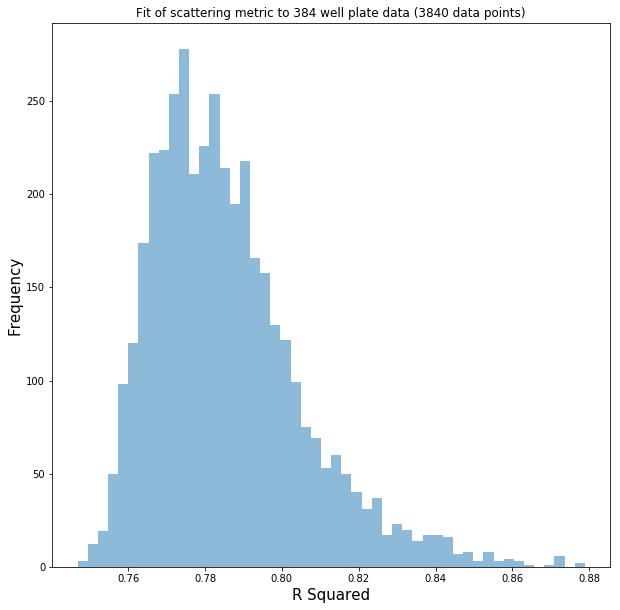

In [458]:
def scattercurve(x, n):

    y = (1/ x)**4 * n

    return y
def fitscattercurve(x,y):
    params = optimize.curve_fit(scattercurve, x,y, p0=[100], maxfev =10000000)
    return params

ndata384 = pd.DataFrame()
for i in range(0, len(data384)):#####time consuming
    y = data384.iloc[i,:]
    x = y.index.values.astype(int)
    
    coefs = fitscattercurve(x,y)[0]
    n= [i for i in coefs]
    n = n[0]

    # R^2
    residuals = y - scattercurve(x,n)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    ndata384 = ndata384.append(pd.Series([r_squared, n], name = y.name))
ndata384. columns =['r_squared', 'n']
plt.figure(figsize=(10,10))
plt.hist(ndata384['r_squared'], bins = 50, alpha = 0.5)
plt.xlabel('R Squared', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title('Fit of scattering metric to 384 well plate data (3840 data points)')
plt.show()

R2 =  -0.11053054069087476
M =  -2397779.0507338885
c =  594195766.4002622


<function matplotlib.pyplot.show(*args, **kw)>

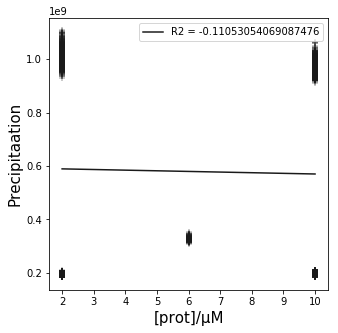

In [484]:
def line(x, m,c):
    y = m*x + c
    return y

'''def line(x, m,c):
    y = m/x**2 + c
    return y
'''
def R2(x,y,m,c):
    # R^2
    residuals = y - line(x,m,c)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

columns = ['Well', 'Vol/µl', '[prot]/µM', '[Substrate]/nl']
x = layouts384['[prot]/µM']
#x = 10*layouts384['[Substrate]/nl']/layouts384['Vol/µl']#layouts384[columns[1]]
#y = ndata384['n']/layouts384['Vol/µl']
y = ndata384['n'].reset_index(drop = True)/layouts384['Vol/µl'].reset_index(drop = True) ### account for volume
cmap = ndata384['r_squared']


params, cov = optimize.curve_fit(line, x,y, p0=[1e+10,-1e+5])
m,c = params[0], params[1]
x2 = np.linspace(x.min(),x.max(), 100)
y2 = line(x2, m,c)


print('R2 = ',R2(x,y,m,c))
print('M = ', m)
print('c = ', c)


plt.figure(figsize=(5,5))
plt.scatter(x,y,
           marker = '+', color = '0.1', alpha = 0.3)#c = cmap)
plt.plot(x2, y2,color = '0.1')
#plt.xlabel('[Substrate/µM]', size = 15)
plt.xlabel(str(x.name), size = 15)
plt.ylabel('Precipitaation', size = 15)
plt.legend(['R2 = '+str(R2(x,y,m,c))])
plt.show

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, MinMaxScaler

#X = normalize(pd.DataFrame(layouts384.drop('Well',axis=1)))
X = pd.DataFrame(layouts384.drop(['Well','Vol/µl'],axis=1))
X = MinMaxScaler.fit_transform(X['[prot]/µM'])
X = MinMaxScaler.fit_transform(X['[Substrate]/nl'])

Y = normalize(pd.DataFrame(y))
regressor = LinearRegression()
regressor.fit(X, Y)

polyX.columns = poly.get_feature_names()

print('Accuracy = ',100*regressor.score(X,Y), ' %')
print('rows/features = ',len(regressor.coef_))
print(len(x))

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [177]:
xdata384 = data384.reset_index().drop('Unnamed: 0',axis=1)


xdata384.loc[ndata384.reset_index().drop('index',axis = 1).sort_values('n').index]

,220,221,222,223,224,225,226,227,228,229,...,791,792,793,794,795,796,797,798,799,800
1328,1.838,1.909,2.156,2.010,2.027,2.273,2.374,2.589,3.041,2.777,...,0.002,0.001,0.001,0.002,0.001,0.002,0.002,0.001,0.001,0.0
3704,1.489,1.676,2.022,1.997,2.027,2.062,2.287,2.659,2.734,2.688,...,0.003,0.000,0.000,0.001,0.001,0.002,0.000,0.000,-0.001,0.0
2867,1.757,1.672,1.845,2.077,2.066,2.098,2.750,2.586,2.600,2.883,...,0.002,0.001,0.000,0.000,0.001,-0.001,0.001,0.003,0.000,0.0
3716,1.562,1.722,2.055,1.991,1.984,2.013,2.244,2.586,2.661,2.598,...,0.002,0.000,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.0
2165,1.807,1.775,1.861,2.056,2.169,2.082,2.210,2.829,2.770,3.056,...,0.004,0.001,0.001,0.002,0.001,0.002,0.001,-0.001,0.000,0.0
1330,1.976,1.857,2.003,2.108,2.204,2.256,2.390,2.444,2.781,2.667,...,0.002,0.000,0.000,0.001,0.001,0.001,0.002,0.001,0.000,0.0
3737,1.619,1.755,2.085,2.104,2.091,2.115,2.300,2.398,2.548,2.583,...,0.003,0.001,0.000,0.001,0.000,0.001,0.001,0.001,0.000,0.0
2065,1.800,1.712,1.969,1.959,2.149,2.257,2.261,2.567,2.488,2.781,...,0.003,0.001,0.000,0.001,0.001,0.001,0.001,0.002,-0.001,0.0
3720,1.515,1.642,2.096,2.106,2.369,2.092,2.295,2.615,2.655,2.531,...,0.002,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.0
3604,1.472,1.720,2.272,2.516,2.457,2.249,2.274,2.423,2.652,2.392,...,0.001,-0.001,-0.002,-0.002,0.001,0.001,0.000,0.000,-0.002,0.0


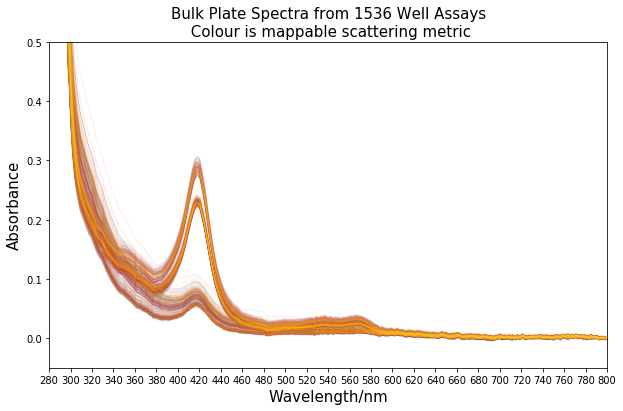

In [373]:
xdata1536 = data1536.reset_index().drop('Unnamed: 0',axis=1)
xdata1536 = xdata1536.loc[ndata1536.reset_index().drop('index',axis = 1).sort_values('n').index].reset_index(drop = True)
### sort by N value (index had re-used plate values)
xdata1536.columns = xdata1536.columns.astype(int)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0,0.9,len(xdata1536))))

for i in range(0,len(xdata1536)):
    plt.plot(xdata384.iloc[i,:],
                lw = 1, alpha = 0.1)

#plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.xticks(np.linspace(280,800,27))
plt.ylabel('Absorbance', size = 15)
plt.xlabel('Wavelength/nm', size = 15)
plt.title('Bulk Plate Spectra from 1536 Well Assays\n Colour is mappable scattering metric', size = 15)

plt.axis(xmin = 280, xmax = 800, ymax = 0.5, ymin = -0.05)

plt.show()

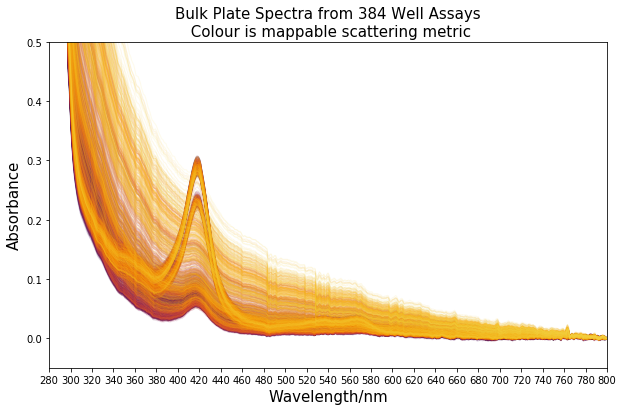

In [372]:
xdata384 = data384.reset_index().drop('Unnamed: 0',axis=1)
xdata384 = xdata384.loc[ndata384.reset_index().drop('index',axis = 1).sort_values('n').index].reset_index(drop = True)
### sort by N value (index had re-used plate values)
xdata384.columns = xdata384.columns.astype(int)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0,0.9,len(xdata384))))

for i in range(0,len(xdata384)):
    plt.plot(xdata384.iloc[i,:],
                lw = 1, alpha = 0.1)

#plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.xticks(np.linspace(280,800,27))
plt.ylabel('Absorbance', size = 15)
plt.xlabel('Wavelength/nm', size = 15)
plt.title('Bulk Plate Spectra from 384 Well Assays\n Colour is mappable scattering metric', size = 15)

plt.axis(xmin = 280, xmax = 800, ymax = 0.5, ymin = -0.05)

plt.show()

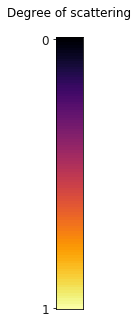

In [350]:
cbar = pd.DataFrame(np.linspace(0,1,101))
fig, ax = plt.subplots(figsize=(10,5))

plt.set_cmap('inferno')
plt.imshow(cbar, aspect = 0.1)
plt.xticks([])

plt.yticks([0,100])
labels = [0,1]
ax.set_yticklabels(labels = labels,
                   size = 12,
                  color = '0.1')
plt.title('Degree of scattering\n')
plt.show()

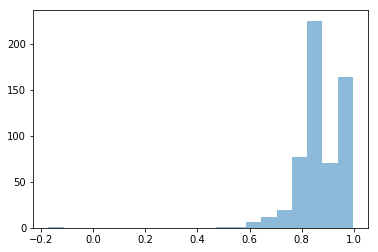

In [269]:
ndata1536 = pd.DataFrame()
for i in range(0, len(data1536)):#####time consuming
    y = data1536.iloc[i,:]
    x = y.index.values.astype(int)
    
    coefs = fitscattercurve(x,y)[0]
    n= [i for i in coefs]
    n = n[0]

    # R^2
    residuals = y - scattercurve(x,n)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    ndata1536 = ndata1536.append(pd.Series([r_squared, n], name = y.name))
ndata1536. columns =['r_squared', 'n']
plt.hist(ndata1536['r_squared'], alpha = 0.5, bins = 20)
plt.show()

R2 =  0.8640729553421103
M =  5.766798922511975e-11
c =  0.21915571155922242


<Figure size 720x504 with 0 Axes>

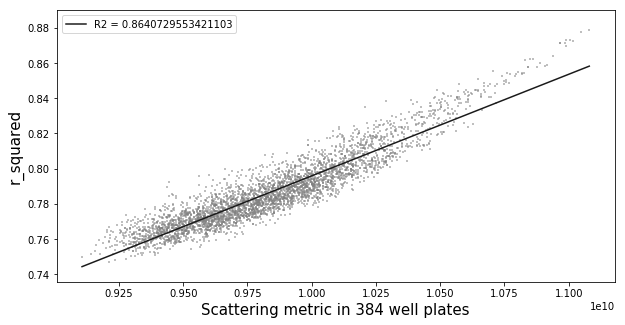

In [362]:
x,y = ndata384['n'],ndata384['r_squared']

plt.figure(figsize=(10,7))
params, cov = optimize.curve_fit(line, x,y, p0=[1e+10,-1e+5])
m,c = params[0], params[1]
x2 = np.linspace(x.min(),x.max(), 10)
y2 = line(x2, m,c)


print('R2 = ',R2(x,y,m,c))
print('M = ', m)
print('c = ', c)

plt.figure(figsize=(10,5))
plt.scatter(x,y,
           s = 5,
           color = '0.5', alpha = 0.5, marker = '+')
plt.plot(x2, y2,color = '0.1')
plt.ylabel('r_squared', size = 15)
plt.xlabel('Scattering metric in 384 well plates', size = 15)
plt.legend(['R2 = '+str(R2(x,y,m,c))])
plt.show()

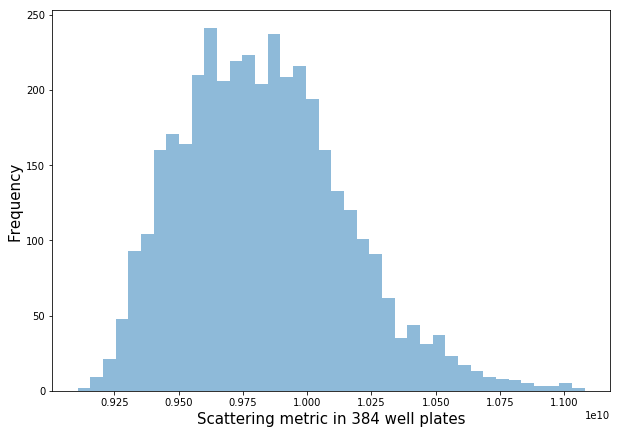

Pearson skewness coef:
2.277386868232822


In [345]:
plt.figure(figsize=(10,7))

plt.hist(ndata384['n'], alpha = 0.5, bins = 40)
plt.ylabel('Frequency', size = 15)
plt.xlabel('Scattering metric in 384 well plates', size = 15)
plt.show()
print('Pearson skewness coef:')
print((ndata384['n'].mean()-ndata384['n'].mode()[0])/ndata384['n'].std())

In [322]:
ndatall = ndata1536.append(ndata384)
layouts384['[Substrate]/µM'] = 10*layouts384['[Substrate]/nl']/layouts384['Vol/µl']

layoutall = layout1536.drop(['Unnamed: 0','No. concs','Power', 'index','Source Well','WellID','Substrate/nl'],axis = 1)
layoutall['[Substrate]/µM'] = layout1536['Substrate/nl']
layoutall.columns = ['Vol/µl', '[prot]/µM', '[Substrate]/µM']
layoutall = layoutall.append(layouts384.drop(['Well','[Substrate]/nl'], axis = 1)).reset_index(drop = True)
print(layoutall.columns)
print(ndatall.columns)

Index(['Vol/µl', '[prot]/µM', '[Substrate]/µM'], dtype='object')
Index(['r_squared', 'n'], dtype='object')


R2 =  1.0
M =  352504.36292616697
c =  8820899852.912745


<function matplotlib.pyplot.show(*args, **kw)>

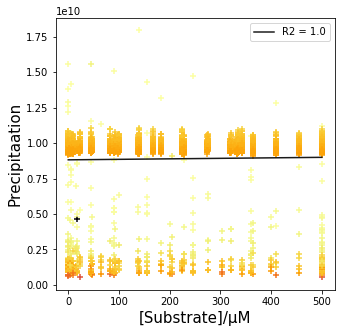

In [326]:
x = layoutall['[Substrate]/µM']
y = ndatall['n']
cmap = ndatall['r_squared']
params, cov = optimize.curve_fit(line, x,y, p0=[1e+10,-1e+5])
m,c = params[0], params[1]
x2 = np.linspace(0,x.max(), 10)
y2 = line(x2, m,c)


print('R2 = ',R2(x,y,m,c))
print('M = ', m)
print('c = ', c)

plt.figure(figsize=(5,5))
plt.scatter(x,y,
           marker = '+',c = cmap)
plt.plot(x2, y2,color = '0.1')
plt.xlabel(str(x.name), size = 15)
plt.ylabel('Precipitaation', size = 15)
plt.legend(['R2 = '+str(R2(x,y,m,c))])
plt.show

C:\Users\MFBX3JE3\Anaconda35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


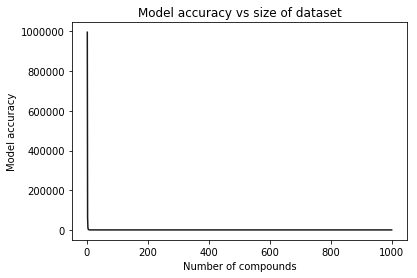

In [471]:
x2 = np.linspace(0,1000,1000)
y2 = (1/x2**4)*10e+5

plt.set_cmap('inferno')
plt.plot(x2, y2,color = '0.1')

plt.title('Model accuracy vs size of dataset')    
plt.ylabel('Model accuracy')
plt.xlabel('Number of compounds')
plt.show()

# Midpoints

In [457]:
Midlayout384 = pd.read_csv('20180918-MidpointPlate layout.csv')
Midlayout384 = Midlayout384.loc[:,['Well','Vol/µl', '[prot]/µM', '0']]
Midlayout384.columns = ['Well','Vol/µl', '[prot]/µM', '[Substrate]/nl']
Midlayout384['[Substrate]/µM'] = 10*Midlayout384['[Substrate]/nl']/Midlayout384['Vol/µl']
Midlayout384 = Midlayout384.append(Midlayout384).reset_index(drop = True)
Midlayout384 = Midlayout384.append(Midlayout384).reset_index(drop = True)
Midata384 = pd.DataFrame()
NamesMidata384 = pd.DataFrame()
files = ['180918_1747.csv','180918_1745.csv']
for i in files:
    data = pd.read_csv(i,
                      skiprows =[0,1,2,3,4,5])
    wells = data.loc[:,'Unnamed: 0':'Unnamed: 1']
    wells = wells['Unnamed: 0'].str.cat(wells['Unnamed: 1'].astype(str))
    data = data.loc[:,'Unnamed: 2':].drop('Unnamed: 584', 
                                  axis = 1)
    name = pd.read_csv(i,
                      nrows =3)['User: USER'][1]
    NamesMidata384 = NamesMidata384.append(pd.Series(name,name = i))
    data = data.where(data['Unnamed: 2'] != 'unused ').dropna()
    data = data.rename(data['Unnamed: 2']).drop(['Unnamed: 2'],
                                        axis = 1)
    data.index= wells.iloc[:len(data)]

    data = data.subtract(data['800'],
                 axis = 0)
    Midata384 = Midata384.append(data)

#data384 = data384.append(Midata384)
#layouts384 = layouts384.append(Midlayout384)

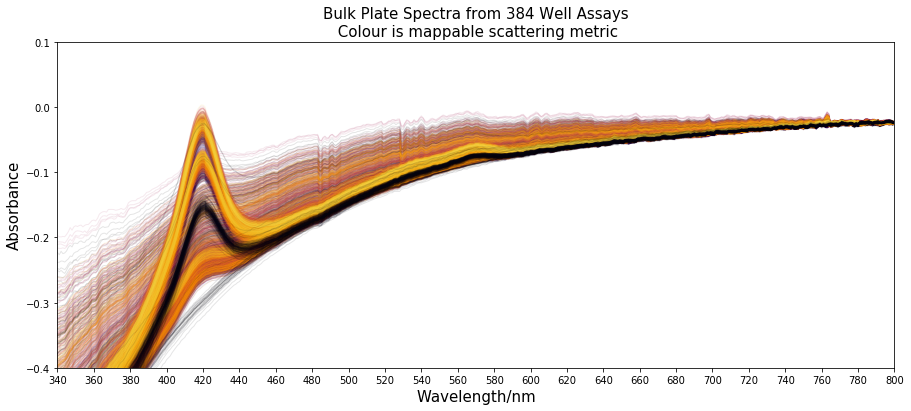

In [510]:
#data384
#ndata384
x = data384.columns.astype(int)
corrections = pd.DataFrame([scattercurve(x,i)for i in ndata384['n']])
corrections.columns = data384.columns
corrections = data384.reset_index(drop = True) - corrections
corrections.columns = corrections.columns.astype(int)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_prop_cycle('color',plt.cm.inferno(np.linspace(0,0.9,len(xdata384))))

for i in range(0,len(corrections)):
    plt.plot(corrections.iloc[i,:],
                lw = 1, alpha = 0.1)

#plt.title('P450 BM3 Wild Type and Fatty Acids in a 1536 well Plate')    
plt.xticks(np.linspace(280,800,27))
plt.ylabel('Absorbance', size = 15)
plt.xlabel('Wavelength/nm', size = 15)
plt.title('Bulk Plate Spectra from 384 Well Assays\n Colour is mappable scattering metric', size = 15)

plt.axis(xmin = 340, xmax = 800, ymax = 0.1, ymin = -0.4)

plt.show()